### Applied Machine Learning 4a

##### Date: April 22 2020
##### Author: Jung Ah Shin 
##### Data source: https://www.kaggle.com/zynicide/wine-reviews


*PREDICT WINE QUALITY FROM REVIEW TEXTS AND OTHER PROPERTIES OF WINE*

### 1.  Bag of Words and Simple Features


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy

import warnings
warnings.filterwarnings('ignore')

import missingno as msno

from sklearn.model_selection import train_test_split, cross_val_score,GridSearchCV,RepeatedKFold
from sklearn.model_selection import cross_validate

from sklearn.compose import ColumnTransformer

from sklearn.compose import make_column_transformer
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.impute import SimpleImputer

from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler

from category_encoders import TargetEncoder, OrdinalEncoder

from sklearn.feature_extraction.text import CountVectorizer

from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet

In [2]:
data = pd.read_csv('winemag-data-130k-v2.csv')
data.drop('Unnamed: 0', inplace=True, axis=1)

# To only use US wine data
only_US = data['country'] == 'US'
data = data[only_US]
data #54504 rows × 14 columns
data.head()

,country,description,designation,points,price,province,region_1,region_2,taster_name,taster_twitter_handle,title,variety,winery
2,US,"Tart and snappy, the flavors of lime flesh and...",NaN,87,14.0,Oregon,Willamette Valley,Willamette Valley,Paul Gregutt,@paulgwine,Rainstorm 2013 Pinot Gris (Willamette Valley),Pinot Gris,Rainstorm
3,US,"Pineapple rind, lemon pith and orange blossom ...",Reserve Late Harvest,87,13.0,Michigan,Lake Michigan Shore,NaN,Alexander Peartree,NaN,St. Julian 2013 Reserve Late Harvest Riesling ...,Riesling,St. Julian
4,US,"Much like the regular bottling from 2012, this...",Vintner's Reserve Wild Child Block,87,65.0,Oregon,Willamette Valley,Willamette Valley,Paul Gregutt,@paulgwine,Sweet Cheeks 2012 Vintner's Reserve Wild Child...,Pinot Noir,Sweet Cheeks
10,US,"Soft, supple plum envelopes an oaky structure ...",Mountain Cuvée,87,19.0,California,Napa Valley,Napa,Virginie Boone,@vboone,Kirkland Signature 2011 Mountain Cuvée Caberne...,Cabernet Sauvignon,Kirkland Signature
12,US,"Slightly reduced, this wine offers a chalky, t...",NaN,87,34.0,California,Alexander Valley,Sonoma,Virginie Boone,@vboone,Louis M. Martini 2012 Cabernet Sauvignon (Alex...,Cabernet Sauvignon,Louis M. Martini


In [3]:
# Remove outliers for price data???

Q1 = data['price'].quantile(0.25)
Q3 = data['price'].quantile(0.75)
IQR = Q3 - Q1

# Then, remove outlier prices 
remove_outlier = (data['price'] >= Q1 - 1.5 * IQR) & (data['price'] <= Q3 + 1.5 * IQR)
data = data.loc[remove_outlier] 
data.describe()

,points,price
count,51958.000000,51958.000000
mean,88.408561,32.878613
std,3.038098,16.277523
min,80.000000,4.000000
25%,86.000000,20.000000
50%,88.000000,30.000000
75%,91.000000,42.000000
max,100.000000,82.000000


##### Categorical vs. Continuous variables

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 51958 entries, 2 to 129967
Data columns (total 13 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   country                51958 non-null  object 
 1   description            51958 non-null  object 
 2   designation            34792 non-null  object 
 3   points                 51958 non-null  int64  
 4   price                  51958 non-null  float64
 5   province               51958 non-null  object 
 6   region_1               51682 non-null  object 
 7   region_2               48012 non-null  object 
 8   taster_name            36065 non-null  object 
 9   taster_twitter_handle  33099 non-null  object 
 10  title                  51958 non-null  object 
 11  variety                51958 non-null  object 
 12  winery                 51958 non-null  object 
dtypes: float64(1), int64(1), object(11)
memory usage: 5.5+ MB


##### Missing data analysis

In [5]:
# Number of nan data for each column
data.isnull().sum()

country                      0
description                  0
designation              17166
points                       0
price                        0
province                     0
region_1                   276
region_2                  3946
taster_name              15893
taster_twitter_handle    18859
title                        0
variety                      0
winery                       0
dtype: int64

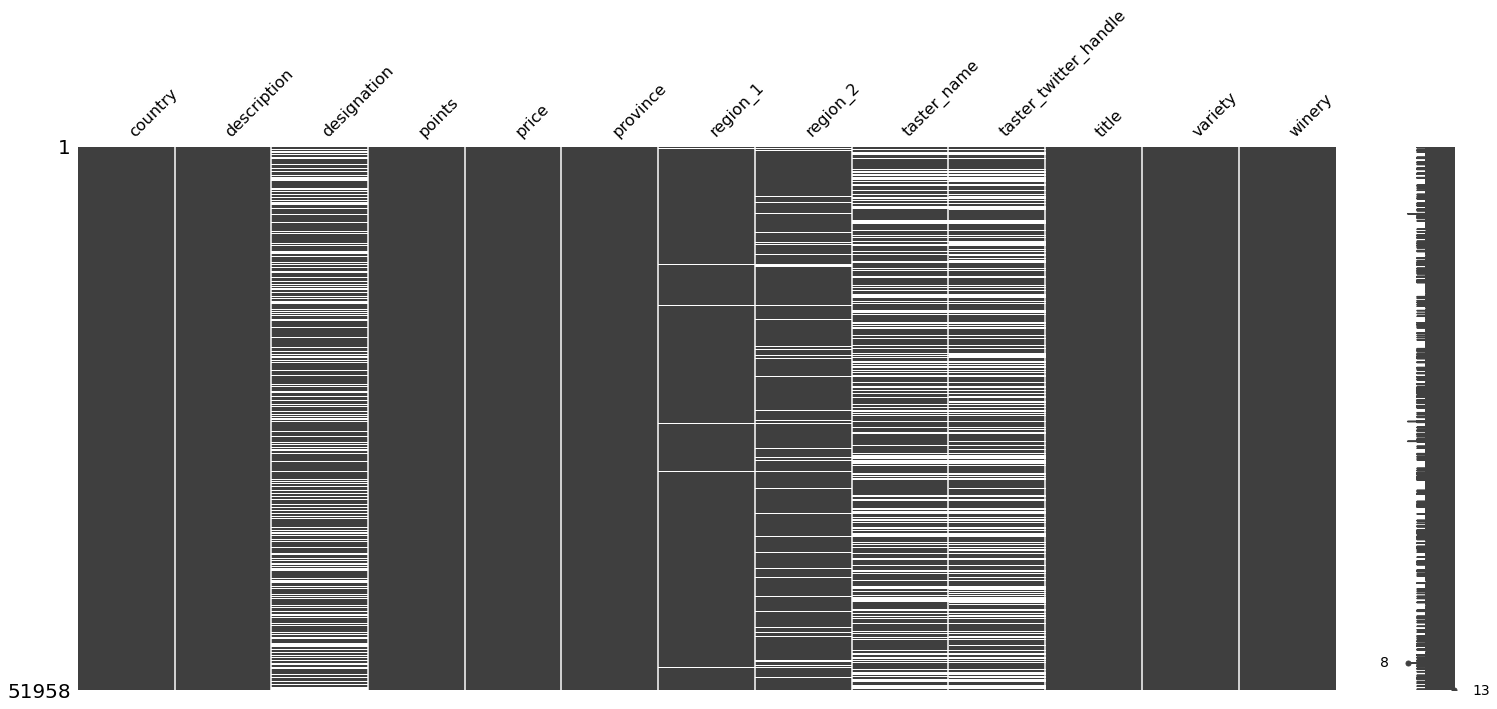

In [6]:
msno.matrix(data);

##### Target variable analysis (points)

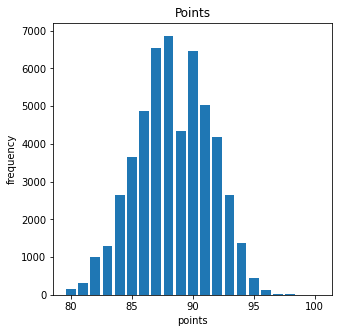

In [7]:
# Target variable analysis (points)

target = data.points.value_counts().to_dict()
fig,ax = plt.subplots(1, figsize=(5,5))
ax.bar(target.keys(), target.values())
ax.set_ylabel('frequency')
ax.set_xlabel('points')

ax.title.set_text('Points')

The target variable `points` refers to points given by WineEnthusiasts on a scale of 1-100 (where only reviews are given for points that are greater than or equal to 80). There are only few observations for points in the early 80s and between 95-100. 


In [8]:
#check num of unique values
#redundant between taster_name & taster_twitter_handle

categorical = ['designation', 'province', 'region_1', 'taster_name', 
                'variety', 'winery']
continuous = ['price']


data_1 = data[['title','description','designation', 'province', 'region_1','taster_name', 
                'variety', 'winery', 'price', 'points']]
data_1

# Drop NAs
#df = data_1.dropna()
df = data_1

X = df.loc[:, ~df.columns.isin(['points'])]
y = df['points']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [9]:
X_train.columns
X_train.designation.nunique()
for col in X_train.columns:
    print(col, X_train[col].nunique())

title 36612
description 36748
designation 11225
province 27
region_1 253
taster_name 15
variety 236
winery 4901
price 79


#### 1.1 Create a baseline model for predicting wine quality using only non-text featurees

`taster_twitter_handle` removed since it is highly likely that `taster_name` would entail the same information as they are both variables indicating who the taster/reviewer was. It is not likely that an individual reviewer would use multiple twitter handles.

`region_2` and `region_1` are also removed. While 
`province`, `region_1`, and `region_2` seem to be hierarchical in a sense that `province` has the broadest information regarding the wine origins, whereas `region_1` and `region_2` provide a more specified information on where the wine was produced.


`title` and `description` are removed since they are text features that need additional feature extraction to find the vintage in the case of `title`, and other preprocessing which will be done for text-based models. 


In [10]:
X_train_1 = X_train[['designation', 'province','taster_name', 
                'variety', 'winery', 'price']] 

X_test_1 = X_test[['designation', 'province','taster_name', 
                'variety', 'winery', 'price']] 
X_train_1.head()

,designation,province,taster_name,variety,winery,price
61776,NaN,California,NaN,Chardonnay,Hess Collection,22.0
89314,Doña Margarita Vineyard Chico's Run Unfiltered,California,Virginie Boone,Pinot Noir,Marimar Estate,55.0
80834,Two Brothers,California,Virginie Boone,Pinot Noir,Donelan,55.0
19723,Sangiacomo Vineyard,California,Virginie Boone,Chardonnay,MacRostie,46.0
11588,NaN,Virginia,NaN,Cabernet Franc,Miracle Valley,26.0


In [11]:
target_encode = ['designation','winery']
onehot_encode = ['variety','province', 'taster_name']
cont_encode = ['price']


target_preprocessing = make_pipeline(
    TargetEncoder()
    )

cat_preprocessing = make_pipeline(
    SimpleImputer(strategy='constant', fill_value='NA'), 
    OneHotEncoder(handle_unknown='ignore')
    )

cont_preprocessing = make_pipeline(
    SimpleImputer(),
    StandardScaler())

preprocess = make_column_transformer(
    (target_preprocessing, target_encode),
    (cat_preprocessing, onehot_encode),
    (cont_preprocessing, cont_encode)
    )

# X_train_scaled = preprocess.fit_transform(X_train)
# X_test_scaled = preprocess.transform(X_test) 

baseline_score = np.mean(cross_val_score(make_pipeline(preprocess, LinearRegression()), 
                              X_train_1, y_train, cv=5))

print("BASELINE CV SCORE: ", "{:.3f}".format(baseline_score))


BASELINE CV SCORE:  0.441


#### 1.2 Create a simple text-based model using a bag-of-words approach and a linear model. 

In [12]:
X_train_2 = X_train[['description']] 
X_test_2 = X_test[['description']]

X_train_title =  X_train[['title']]
X_test_title =  X_test[['title']]

#BOW model 
vect = CountVectorizer(stop_words='english', max_features=2500)
X_train_3 = vect.fit_transform(X_train_2.description)


In [13]:
simple_bow_score = np.mean(cross_val_score(make_pipeline(Ridge()), 
                              X_train_3, y_train, cv=5))


print("Simple bag-of-words CV SCORE: ", "{:.3f}".format(simple_bow_score))

Simple bag-of-words CV SCORE:  0.659


#### 1.3 Try using n-grams, characters, tf-idf rescaling and possibly other ways to tune the BoW model. 

Note: Might need to adjust the (regularization of the) linear model for different feature sets.

##### n-grams

In [14]:
#NGRAM

ngram_vect = CountVectorizer(ngram_range=(1,2),max_features=3500,stop_words='english')

X_train_4 = ngram_vect.fit_transform(X_train_2.description)

In [15]:
ngram_score = np.mean(cross_val_score(make_pipeline(Ridge()), 
                              X_train_4, y_train, cv=5))

print("n-grams CV SCORE: ", "{:.3f}".format(ngram_score))

n-grams CV SCORE:  0.651


##### tf-idf rescaling 

In [16]:
#TF-IDF Rescaling
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf_vect = TfidfVectorizer()

X_train_5 = tfidf_vect.fit_transform(X_train_2.description)

X_train_5
#<38968x17339 sparse matrix of type '<class 'numpy.float64'>'
#with 1349167 stored elements in Compressed Sparse Row format>


<38968x17339 sparse matrix of type '<class 'numpy.float64'>'
	with 1349167 stored elements in Compressed Sparse Row format>

In [17]:
tfidf_score = np.mean(cross_val_score(make_pipeline(Ridge()), 
                              X_train_5, y_train, cv=5))

print("tf-idf CV SCORE: ", "{:.3f}".format(tfidf_score))

tf-idf CV SCORE:  0.684


#### 1.4 Combine the non-text features and the text features. 

In [18]:
## X_train_text = X_train[['description', 'title']]

target_encode = ['designation','winery']
onehot_encode = ['variety','province', 'taster_name']
cont_encode = ['price']

cont_t = Pipeline(steps=[
    ('imputer', SimpleImputer()),
    ('scaler', StandardScaler())
])

target_t = Pipeline(steps=[
    ('targetenc', TargetEncoder())
])

cat_t = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='NA')),
    ('onehot',  OneHotEncoder(handle_unknown='ignore'))
])

transformer = make_column_transformer(
        (cont_t, cont_encode),
        (cat_t, onehot_encode),
        (target_t, target_encode),
        remainder="passthrough"
    )

X_train_scaled = transformer.fit_transform(X_train_1,y_train)

#vect = CountVectorizer(stop_words='english', max_features=2000)
vect = TfidfVectorizer(max_features=1500)
#vect = CountVectorizer(ngram_range=(1,2),max_features=2000,stop_words='english')
X_train_description =  vect.fit_transform(X_train_2.description)

X_train_title_1 = vect.fit_transform(X_train_title.title)

X_train_6 = scipy.sparse.hstack((X_train_scaled, X_train_description))#, X_train_title_1

print(X_train_6.shape)

(38968, 1782)


In [19]:
combine_score = np.mean(cross_val_score(Ridge(), 
                              X_train_6, y_train, cv=5))

print("Combined CV SCORE: ", "{:.3f}".format(combine_score)) 

Combined CV SCORE:  0.773


#### 1.5 Summary

In [20]:
print("BASELINE CV SCORE: ", "{:.3f}".format(baseline_score))
print("Simple bag-of-words CV SCORE: ", "{:.3f}".format(simple_bow_score))
print("n-grams CV SCORE: ", "{:.3f}".format(ngram_score))
print("tf-idf CV SCORE: ", "{:.3f}".format(tfidf_score))
print("Combined CV SCORE: ", "{:.3f}".format(combine_score)) 

BASELINE CV SCORE:  0.441
Simple bag-of-words CV SCORE:  0.659
n-grams CV SCORE:  0.651
tf-idf CV SCORE:  0.684
Combined CV SCORE:  0.773



Based on the summary of scores above, the model that combined non-text features and text features (using tf-idf) outperformed the other models (Average R^2 score: 0.773). 

The baseline (using only non-text features) had the lowest R^2 score of 0.441. It can be concluded that adding text features provide additional information on the data, allowing for the linear model to perform better. 
